In [3]:
import pandas as pd # used to load, manipulate the data and for one-hot encoding
import numpy as np # data manipulation
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample # for downsample the dataset
from sklearn.model_selection import train_test_split # for splitting the dataset into train and test split
from sklearn.preprocessing import scale # scale and center the data
from sklearn.svm import SVC # will make a SVM for classification
from sklearn.model_selection import GridSearchCV # will do the cross validation
from sklearn.metrics import plot_confusion_matrix # will draw the confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_curve, auc
import seaborn as sns

In [4]:
df = pd.read_csv(r'C:\Users\Dell\Desktop\OASISProject\oasis_longitudinal.csv')

In [5]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [6]:
# Since all subjects are right-handed, we will drop this column. Also, Subject ID and
# MRI ID are used for uniquely identifying the patient and have no role to play in our 
# model and so, will be dropped
df=df.drop(['Subject ID','MRI ID','Hand'],axis=1)

In [26]:
df.shape

(373, 12)

In [28]:
missing_values_count = df.isnull().sum()
missing_values_count[0:12]

Group        0
Visit        0
MR Delay     0
M/F          0
Age          0
EDUC         0
SES         19
MMSE         2
CDR          0
eTIV         0
nWBV         0
ASF          0
dtype: int64

In [7]:
# Replacing missing values in SES and MMSE with median values
df['SES'].fillna((df['SES'].median()), inplace=True)
df['MMSE'].fillna((df['MMSE'].median()), inplace=True)


In [8]:
# Converting M/F and Group coulumns to numeric data 
df['M/F'] = df['M/F'].replace(['M', 'F'], [1,0])
df['Group'] = [1 if each == "Demented" or each == "Converted" else 0 for each in df['Group']]

In [9]:
df.head()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,1,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,0,2,457,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,1,0,1,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,1,2,560,1,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,1,3,1895,1,80,12,2.0,22.0,0.5,1698,0.701,1.034


In [10]:
correlation = df.corr()
df_corr = correlation['Group'].sort_values(ascending=False)
df_corr

Group       1.000000
CDR         0.778049
M/F         0.222146
SES         0.038870
ASF         0.032495
Age        -0.005941
eTIV       -0.042700
Visit      -0.095507
MR Delay   -0.120638
EDUC       -0.193060
nWBV       -0.311346
MMSE       -0.520553
Name: Group, dtype: float64

In [9]:
X = df.copy()
y = X.pop("Group")
discrete_features = X.dtypes == int

In [16]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

CDR         0.534310
MMSE        0.186035
nWBV        0.094885
ASF         0.082849
eTIV        0.076415
M/F         0.059319
SES         0.049369
EDUC        0.047557
Age         0.021822
Visit       0.002663
MR Delay    0.000000
Name: MI Scores, dtype: float64

<AxesSubplot:>

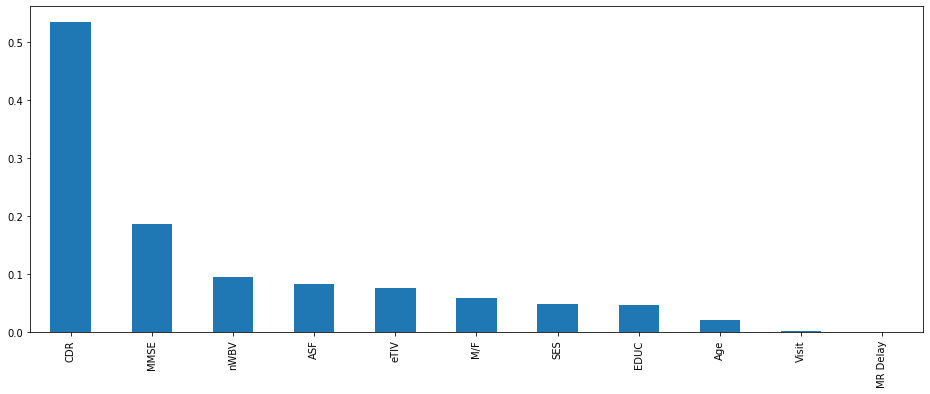

In [17]:
mi_scores.sort_values(ascending=False).plot.bar(figsize=(16, 6))

In [10]:
 #we will drop MR delay column
df.drop(columns=['MR Delay' , 'Visit'])

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,0,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,1,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,1,1,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,1,1,80,12,2.0,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...
368,1,1,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,1,1,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,0,0,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,0,0,63,13,2.0,30.0,0.0,1327,0.796,1.323


<AxesSubplot:xlabel='M/F', ylabel='CDR'>

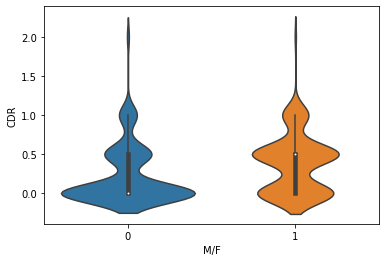

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.violinplot(x="M/F" , y="CDR",kind='swarm', data = df)

In [12]:
from sklearn.model_selection import train_test_split 
y = df['Group'].values
X = df[['M/F', 'Age', 'EDUC','MMSE', 'SES', 'eTIV', 'nWBV', 'ASF']].values


In [13]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size= 0.20, random_state=42, stratify=y)

df_ytrain = pd.DataFrame(y_trainval)
df_ytest = pd.DataFrame(y_test)

print('In Training Split:')
print(df_ytrain[0].value_counts())

print('\nIn Testing Split:')
print(df_ytest[0].value_counts())

In Training Split:
0    152
1    146
Name: 0, dtype: int64

In Testing Split:
0    38
1    37
Name: 0, dtype: int64


In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
scaler = StandardScaler().fit(X_trainval)
#scaler = MinMaxScaler().fit(X_trainval)
#scaler = RobustScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

In [79]:
from sklearn.svm import SVC 
clf_svm = SVC(random_state=42)
clf_svm.fit(X_trainval_scaled, y_trainval)
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_curve, auc
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

train_score = clf_svm.score(X_trainval_scaled, y_trainval)
test_score = clf_svm.score(X_test_scaled, y_test)
y_predict = clf_svm.predict(X_test_scaled)
test_recall = recall_score(y_test, y_predict)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(fpr, tpr)
print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

Train accuracy  0.8590604026845637
Test accuracy  0.7466666666666667
Test recall 0.5945945945945946
Test AUC 0.744665718349929


In [81]:
param_grid = [

    {'C': [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 50, 80, 100],
    'gamma': ['scale', 0.5, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
]

optimal_params = GridSearchCV(SVC(),
                             param_grid,
                             cv=5, # we are taking 5-fold as in k-fold cross validation
                             scoring='accuracy', # try the other scoring if have time
                             verbose=0,
                             n_jobs=-1)

optimal_params.fit(X_trainval_scaled, y_trainval)
print(optimal_params.best_params_)

{'C': 6, 'gamma': 1, 'kernel': 'rbf'}


In [82]:
C = optimal_params.best_params_['C']
gamma = optimal_params.best_params_['gamma']
kernel = optimal_params.best_params_['kernel']

In [83]:
clf_svm = SVC(random_state=42, C=C, gamma=gamma, kernel=kernel)
clf_svm.fit(X_trainval_scaled, y_trainval)

SVC(C=6, gamma=1, random_state=42)

In [84]:
train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

train_score = clf_svm.score(X_trainval_scaled, y_trainval)
test_score = clf_svm.score(X_test_scaled, y_test)
y_predict = clf_svm.predict(X_test_scaled)

test_recall = recall_score(y_test, y_predict)
svm_fpr, svm_tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(svm_fpr, svm_tpr)

print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

Train accuracy  1.0
Test accuracy  0.92
Test recall 0.918918918918919
Test AUC 0.9199857752489331


In [48]:
n_estimators = range(10,250)
max_features = ['auto', 'sqrt']
max_depth = range(1,40)
min_samples_split = range(3,60)

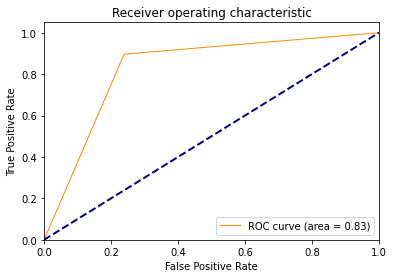


Acuuracy Of the Model:  0.8133333333333334 




In [145]:
#parametro_rf = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split}
total_accuracy = {}
def accuracy(model):
    pred = model.predict(X_test_scaled)
    accu = metrics.accuracy_score(y_test,pred)
    print("\nAcuuracy Of the Model: ",accu,"\n\n")
    total_accuracy[str((str(model).split('(')[0]))] = accu
    
total_fpr = {}
total_tpr = {}
def roc_curves(model):
    predictions_test = model.predict(X_test_scaled)
    fpr, tpr, thresholds = roc_curve(predictions_test,y_test)
    roc_auc = auc(fpr, tpr)
    total_fpr[str((str(model).split('(')[0]))] = fpr
    total_tpr[str((str(model).split('(')[0]))] = tpr
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

rfc=RandomForestClassifier(criterion='gini',max_depth=8,max_features='auto',n_estimators=200)

param_grid = { 
    'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini']
}

#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,scoring = 'roc_auc')
rfc.fit(X_trainval_scaled, y_trainval.ravel())
#print("Best parameters set found on development set:")
#print(rfc.best_params_)
#report_performance(rfc) 
roc_curves(rfc)
accuracy(rfc)

#feat_importances = pd.Series(rfc.feature_importances_, index=feature_col_names)
#feat_importances.nlargest(8).plot(kind='barh')
#plt.title("Feature Importance:")
#plt.show()

In [50]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import RandomizedSearchCV
FOLDS =10
model_forest = RandomForestClassifier(n_jobs=-1)
forest_random = RandomizedSearchCV(estimator = model_forest, param_distributions = parametro_rf, n_iter = 100, cv = FOLDS, 
                               verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_absolute_error')
forest_random.fit(X_trainval_scaled, y_trainval)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 40),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': range(3, 60),
                                        'n_estimators': range(10, 250)},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [51]:
forest_random.best_params_

{'n_estimators': 46,
 'min_samples_split': 3,
 'max_features': 'sqrt',
 'max_depth': 20}

In [52]:
model_rf = forest_random.best_estimator_
model_rf =  RandomForestClassifier(n_estimators=60,min_samples_split=8,max_features='sqrt',max_depth= 37)
model_rf.fit(X_trainval_scaled,y_trainval)

RandomForestClassifier(max_depth=37, max_features='sqrt', min_samples_split=8,
                       n_estimators=60)

In [53]:
Predicted_rf= model_rf.predict(X_test_scaled)
test_recall = recall_score(y_test, Predicted_rf, pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, Predicted_rf, pos_label=1)
test_auc = auc(fpr, tpr)

In [64]:
acc = []
model='Random Forest'
test_score = cross_val_score(model_rf, X_trainval_scaled, y_trainval, cv=FOLDS, scoring='accuracy').mean() # Get recall for each parameter setting
test_recall = recall_score(y_test, Predicted_rf, pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, Predicted_rf, pos_label=1)
test_auc = auc(fpr, tpr)
#acc.append([model,test_score, test_recall, test_auc])
#print(acc)
#print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

Test accuracy  0.8355172413793104
Test recall 0.6216216216216216
Test AUC 0.7450213371266002


In [69]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from kerastuner.tuners import Hyperband
from tensorflow.keras import layers

AlreadyExistsError: Another metric with the same name already exists.

In [66]:
!pip install -q -U keras-tuner

In [68]:
print(tf.__version__)

NameError: name 'tf' is not defined

In [30]:
def build_model(hp):
  model = keras.Sequential()
  
  for i in range(hp.Int('number_of_layers',2,7)):
    model.add(
        layers.Dense(
            units= hp.Int(
                'unit_'+str(i), 
                min_value = 2, 
                max_value = 100, 
                step = 32), 
                activation = 'relu'))
  
  model.add(layers.Dense(20, activation = 'linear'))   
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile( 
      keras.optimizers.Adam(hp.Choice(
          'learning_rate', [1e-2, 1e-3, 1e-4])), 
          loss='binary_crossentropy', 
          metrics=['accuracy'])
  
  return model

In [31]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='model_loan1'
    )

In [32]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
number_of_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 7, 'step': 1, 'sampling': None}
unit_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 100, 'step': 32, 'sampling': None}
unit_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 100, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [98]:
tuner.search(X_trainval_scaled,y_trainval,epochs = 5, validation_data = (X_trainval_scaled,y_test))


Search: Running Trial #10

Hyperparameter    |Value             |Best Value So Far 
number_of_layers  |6                 |?                 
unit_0            |66                |?                 
unit_1            |66                |?                 
learning_rate     |0.001             |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |1                 |?                 
tuner/round       |0                 |?                 
unit_2            |2                 |?                 
unit_3            |2                 |?                 
unit_4            |2                 |?                 
unit_5            |2                 |?                 



ValueError: Data cardinality is ambiguous:
  x sizes: 8
  y sizes: 298
Make sure all arrays contain the same number of samples.

In [105]:
!pip install --upgrade scikit-learn==0.20.3

  ERROR: Command errored out with exit status 1:
   command: 'c:\users\dell\appdata\local\programs\python\python39\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Dell\\AppData\\Local\\Temp\\pip-install-_fs4l7jn\\scikit-learn_b9548665244a40dd938e4c71bb689f0c\\setup.py'"'"'; __file__='"'"'C:\\Users\\Dell\\AppData\\Local\\Temp\\pip-install-_fs4l7jn\\scikit-learn_b9548665244a40dd938e4c71bb689f0c\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Dell\AppData\Local\Temp\pip-wheel-ayee75k1'
       cwd: C:\Users\Dell\AppData\Local\Temp\pip-install-_fs4l7jn\scikit-learn_b9548665244a40dd938e4c71bb689f0c\
  Complete output (678 lines):
  Partial import of sklearn during the build process.
  blas_opt_info:
  blas_mkl_info:
  No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils



  Running setup.py clean for scikit-learn
Failed to build scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
    Running setup.py install for scikit-learn: started
    Running setup.py install for scikit-learn: finished with status 'error'
  Rolling back uninstall of scikit-learn
  Moving to c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\scikit_learn-0.24.1.dist-info\
   from C:\Users\Dell\AppData\Local\Programs\Python\Python39\Lib\site-packages\~cikit_learn-0.24.1.dist-info
  Moving to c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\sklearn\
   from C:\Users\Dell\AppData\Local\Programs\Python\Python39\Lib\site-packages\~klearn


  customize Gnu95FCompiler
  Could not locate executable gfortran
  Could not locate executable f95
  customize G95FCompiler
  Could not locate executable g95
  customize IntelEM64VisualFCompiler
  customize IntelEM64TFCompiler
  Could not locate executable efort
  Could not locate executable efc
  customize PGroupFlangCompiler
  Could not locate executable flang
  don't know how to compile Fortran code on platform 'nt'
    NOT AVAILABLE
  
  atlas_3_10_blas_threads_info:
  Setting PTATLAS=ATLAS
    libraries tatlas not found in ['c:\\users\\dell\\appdata\\local\\programs\\python\\python39\\lib', 'C:\\', 'c:\\users\\dell\\appdata\\local\\programs\\python\\python39\\libs']
    NOT AVAILABLE
  
  atlas_3_10_blas_info:
    libraries satlas not found in ['c:\\users\\dell\\appdata\\local\\programs\\python\\python39\\lib', 'C:\\', 'c:\\users\\dell\\appdata\\local\\programs\\python\\python39\\libs']
    NOT AVAILABLE
  
  atlas_blas_threads_info:
  Setting PTATLAS=ATLAS
    libraries ptf77bla

In [108]:
#import sklearn.external.joblib as joblib
import joblib

In [111]:
from joblib import dump, load
dump(scaler, 'std_scaler.bin', compress=True)
std=load('std_scaler.bin')
from sklearn.metrics import accuracy_score

'''standardize the test data before prediction
    and predict the result.'''

df_test_scaled = std.transform(X_test_scaled)
y_prediction = model.predict_classes(df_test_scaled)
print("\n\nThe Test Accuracy of the model is: {} %".format(accuracy_score(y_test, y_predict) * 100.))



The Test Accuracy of the model is: 74.66666666666667 %


C:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ExtraTreesClassifier : 


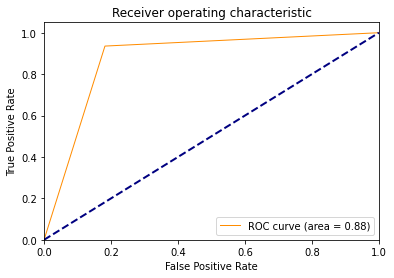


Acuuracy Of the Model:  0.8666666666666667 




In [29]:
#from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
total_accuracy = {}
def accuracy(model):
    pred = model.predict(X_test_scaled)
    accu = metrics.accuracy_score(y_test,pred)
    print("\nAcuuracy Of the Model: ",accu,"\n\n")
    total_accuracy[str((str(model).split('(')[0]))] = accu
    
total_fpr = {}
total_tpr = {}
def roc_curves(model):
    predictions_test = model.predict(X_test_scaled)
    fpr, tpr, thresholds = roc_curve(predictions_test,y_test)
    roc_auc = auc(fpr, tpr)
    total_fpr[str((str(model).split('(')[0]))] = fpr
    total_tpr[str((str(model).split('(')[0]))] = tpr
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import ExtraTreeClassifier
model = ExtraTreesClassifier()
print(str(model).split('(')[0],": ")
model.fit(X_trainval_scaled,y_trainval.ravel())
X = pd.DataFrame(X_trainval_scaled)
#report_performance(model)
roc_curves(model)
accuracy(model)